# Symbolic Regression Study on Lennard-Jones potential

## Overview
LJ potential is a classic potential that describe the interaction between two atoms.

A classic form of LJ potential is the 12-6 form

$$V_{ij}= 4 \epsilon_{ij}[(\frac {\sigma_{ij}} {r_{ij}})^{12} - (\frac {\sigma_{ij}} {r_{ij}})^{6}]$$

## Goal
Fit LJ potential equations using Symbolic regression

## LJ potential

A typical LJ potential profile is:
<p align=center>
<img src="images/LJ.png" width=400>
<p>

And the equation is:
\begin{align}
 U(r_{ij}) &= E_{ele} + E_{VDW} \\ &= \frac {Q_i Q_j} {4\pi \epsilon_0 r_{ij}} + \frac A {r_{ij}^{12}} + \frac B {r_{ij}^{6}} \\ &= \frac {Q_i Q_j} {4\pi \epsilon_0 r_{ij}} + \epsilon_{ij}[ (\frac {R_{min, ij}} {r_{ij}})^{12} - 2(\frac {R_{min, ij}} {r_{ij}})^{6}] \\ &= \frac {Q_i Q_j} {4\pi \epsilon_0 r_{ij}} + 4 \epsilon_{ij}[(\frac {\sigma_{ij}} {r_{ij}})^{12} - (\frac {\sigma_{ij}} {r_{ij}})^{6}] 
 \end{align}

where $\sigma_{ij}$ is the distance where the LJ interaction potential between 2 particles is 0

$R_{min,ij}$ is the distance at which the LJ potential has its minimum value

$\epsilon$ is the well depth and a measure of how strongly the two particles attract each other

$r$ is the distance of separation between both particles (measured from the center of one particle to the center of the other particle)

## Curve fitting
### Import packages

In [1]:
#loading packages & dependencies
#When the %pylab magic function is entered at the IPython prompt, it triggers the import of various modules within Matplotlib.
%pylab inline 
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.optimize import curve_fit

# import a symbolic mathematic conversion tool package
from sympy import *
import graphviz


Bad key savefig.frameon in file /Users/Collin/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/Collin/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/Collin/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a 

Populating the interactive namespace from numpy and matplotlib


### Prepare the LJ potential function

In [2]:
# A LJ function
def lennard_jones(r):
    epsilon = 0.17
    sigma = 3.25
    return 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)

eq = '4 * epsilon * (pow_12(sigma/r) - pow_6(sigma/r))'

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x / y,
    'mul': lambda x, y : x * y,
    'add': lambda x, y : x + y,
    'pow_6':lambda x: x**6,
    'pow_12':lambda x: x**12
}

sympify(eq, locals=converter)

4*epsilon*(-sigma**6/r**6 + sigma**12/r**12)

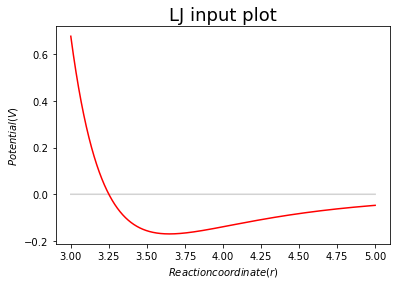

In [3]:
r = np.arange(3, 5, 0.001)       # Reaction coordinate
y_truth = lennard_jones(r)       # true function value

dash_line_x = r
dash_line_y = np.array([0] * len(r))

X_train = r
y_train = y_truth

plt.title("LJ input plot", fontsize=18)
plt.xlabel('$Reaction coordinate (r)$')
plt.ylabel('$Potential (V)$')
plt.plot(dash_line_x, dash_line_y, color='lightgrey')
plt.plot(X_train, y_train, color='red')
plt.show()

## Symbolic Regression
### Define training function

In [4]:
# Define functions
def my_power(b:float, n:float):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(np.abs(b.any()) < 20 and np.abs(n.any()) < 13, np.power(b, n), 0.)

def _epsilon_div(x):
    epsilon = 0.17
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(np.abs(x) > 0.001, np.divide(epsilon, x), 1.)

def _sigma_div(x):
    sigma = 3.25
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(np.abs(x) > 0.001, np.divide(sigma, x), 1.)

def m_pow_2(x):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x) < 10, np.power(x, 2), 0.)

def m_pow_3(x):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x) < 10, np.power(x, 3), 0.)

def m_pow_6(x):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x) < 10, np.power(x, 6), 0.)

def m_pow_12(x):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x) < 10, np.power(x, 12), 0.)

my_pow = make_function(function=my_power, name='pow', arity=2)
pow_2 = make_function(function=m_pow_2, name='pow_2', arity=1)
pow_3 = make_function(function=m_pow_3, name='pow_3', arity=1)
pow_6 = make_function(function=m_pow_6, name='pow_6', arity=1)
pow_12 = make_function(function=m_pow_12, name='pow_12', arity=1)
epsilon_div = make_function(function=_epsilon_div, name='epsilon_mul', arity=1)
sigma_div = make_function(function=_sigma_div, name='sigma_div', arity=1)

# Define all the available operators in the symbolic regression
func_set = ['add', 'sub', 'mul', 'div', pow_6, pow_12, epsilon_div, sigma_div]
# func_set = ['add', 'sub', 'mul', 'div', pow_2, pow_3, epsilon_div, sigma_div]

func_name_set = []
for func in func_set:
    if not isinstance(func, str):
        func = func.name
    func_name_set.append(func)

### Train the model

In [5]:
# Compile a symbolic regressor
est_gp = SymbolicRegressor(population_size=5000,     # The number of programs in each generation
                           const_range=(-1, 1),
                           function_set=func_set,
                           generations=30, 
                           metric='mse',             # cost function, need to get a suitable cost function
                           stopping_criteria=0.001,  # The required metric value required in order to stop evolution early.
                           p_crossover=0.5, 
                           p_subtree_mutation=(1-0.5)/3,
                           p_hoist_mutation=(1-0.5)/3,   # 0.05, The probability of performing hoist mutation on a tournament winner. Hoist mutation takes the winner of a tournament and selects a random subtree from it. A random subtree of that subtree is then selected and this is ‘hoisted’ into the original subtrees location to form an offspring in the next generation. This method helps to control bloat.
                           p_point_mutation=1-0.5-(1-0.5)/3-(1-0.5)/3, 
                           max_samples=0.9, verbose=1,
                           tournament_size=20,
                           parsimony_coefficient=0.0005, random_state=0)

# X is an array of shape (n_samples, n_features), if there is only one feature, then reshape the one D array into (-1, 1)
est_gp.fit(X_train.reshape(-1, 1), y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/Users/Collin/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in true_divide
  
/Users/Collin/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/gplearn/functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)
/Users/Collin/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':


   0    15.94      1.81373e+31        7       0.00575413       0.00484048      2.88m
   1     5.20      2.95914e+20        7       0.00556921       0.00650474      1.98m
   2     4.72      5.99232e+19        7       0.00549682       0.00715628      1.80m
   3     4.60      5.52875e+19        7       0.00539022       0.00811564      1.61m
   4     5.31      5.28369e+20        9       0.00380393       0.00472599      1.66m
   5     6.80      8.51761e+19        9       0.00380038       0.00475796      1.88m
   6     7.19      3.29359e+21        9       0.00369059       0.00574599      1.84m
   7     7.86      4.32989e+20        9      0.000662723      0.000737848      1.78m


SymbolicRegressor(const_range=(-1, 1),
                  function_set=['add', 'sub', 'mul', 'div',
                  generations=30, max_samples=0.9, metric='mse',
                  p_crossover=0.5, p_hoist_mutation=0.16666666666666666,
                  p_point_mutation=0.1666666666666667,
                  p_subtree_mutation=0.16666666666666666,
                  parsimony_coefficient=0.0005, population_size=5000,
                  random_state=0, stopping_criteria=0.001, verbose=1)

### Get output equation and score

In [6]:
# Get the score of this training
score_gp = est_gp.score(X_train.reshape(-1, 1), y_train)
print(f"The symbolic regression score is: {score_gp:.4f}")

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x / y,
    'mul': lambda x, y : x * y,
    'add': lambda x, y : x + y,
    'pow_2':lambda x: x**2,
    'pow_3':lambda x: x**3,
    'pow_6':lambda x: x**6,
    'pow_12':lambda x: x**12,
    'epsilon_mul': lambda x: 0.17 * x,
    'sigma_div': lambda x: 3.25 / x,
}

print("The math equation is:")
print(str(est_gp._program))
sympify(str(est_gp._program), locals=converter)

The symbolic regression score is: 0.9691
The math equation is:
mul(0.790, sub(pow_12(sigma_div(X0)), pow_6(sigma_div(X0))))


-930.951931152344/X0**6 + 1097052.52926111/X0**12

### Compare with the real LJ function

In [7]:
eq = '4 * 0.17 * (pow_12(3.25/r) - pow_6(3.25/r))'

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x / y,
    'mul': lambda x, y : x * y,
    'add': lambda x, y : x + y,
    'pow_6':lambda x: x**6,
    'pow_12':lambda x: x**12
}

sympify(eq, locals=converter)

-801.325712890625/r**6 + 944298.379617159/r**12

### Define testing dataset, plot test curve and save the log

/Users/Collin/PycharmProjects/Symbolic_Regression_Lennard-Jones_potential/LJ_fitting_outputs
/Users/Collin/PycharmProjects/Symbolic_Regression_Lennard-Jones_potential


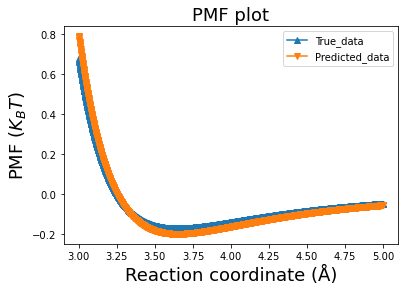

In [8]:
X_test = X_train
Y_test = y_train

# Get the prediction
y_predict = est_gp.predict(X_test.reshape(-1, 1))

plt.plot(X_test, Y_test, marker='^', label='True_data')
plt.plot(X_test, y_predict, marker='v', label='Predicted_data')

plt.title("PMF plot", fontsize=18)
plt.xlabel('Reaction coordinate (Å)', fontsize=18)
plt.ylabel('PMF $(K_B T)$', fontsize=18)
plt.legend()
# plt.text(5.0, 6.0, f'$score = $ {score_gp:.4f}', size=14)

# Save output in an individual directory
%cd LJ_fitting_outputs/
trial_name = 'lj_fitting_x_3_to_5'

plt.savefig(f'{trial_name}.png', dpi=300)
with open(trial_name + '.log', 'a') as f:
    f.write(f'\n\nThe current trial is: \n{trial_name}\n\n')
    f.write(f'The employed function set is: \n{func_name_set}\n\n')
    f.write(f"The symbolic regression score is: {score_gp}\n\n")
    f.write(f'The equation is:\n {str(est_gp._program)}\n\n')
    f.write("Model parameters are:\n")
    f.write(f"The stopping criteria is: {est_gp.stopping_criteria}\n\n")
    f.write(f"Population size -> {est_gp.population_size}\n")
    f.write(f"# of generations -> {est_gp.generations}\n")
    f.write(f"const_range -> {est_gp.const_range}\n")
    f.write(f"p_crossover -> {est_gp.p_crossover}\n")
    f.write(f"p_subtree_mutation -> {est_gp.p_subtree_mutation}\n")
    f.write(f"p_point_mutation -> {est_gp.p_point_mutation}\n")
    f.write(f"p_hoist_mutation -> {est_gp.p_hoist_mutation}\n")
    f.write(f"parsimony_coefficient -> {est_gp.parsimony_coefficient}\n")

# pickle the trained model
with open(trial_name + f'_pickle_model', 'wb') as pickle_model_file:
    pickle.dump(est_gp, pickle_model_file)

%cd ../

plt.show()

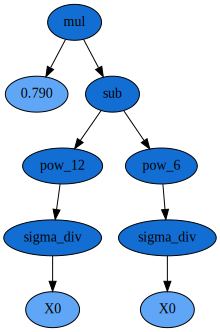

In [9]:
vis_data = est_gp._program.export_graphviz()
graph = graphviz.Source(vis_data)
graph.render('Tree_charts/test', format='png', cleanup=True)
graph

### Reload the pickled model

In [10]:
pickled_file = 'LJ_fitting_outputs/lj_fitting_pickle_model'
with open(pickled_file, 'rb') as f:
    restart_gp = pickle.load(f)

# Get the score of this training
new_score_gp = restart_gp.score(X_train.reshape(-1, 1), y_train)
print(f"The symbolic regression score is: {new_score_gp:.4f}")

The symbolic regression score is: 0.9832


## Polynomial Fitting method

The parameters are: [12.    6.    0.17  3.25]


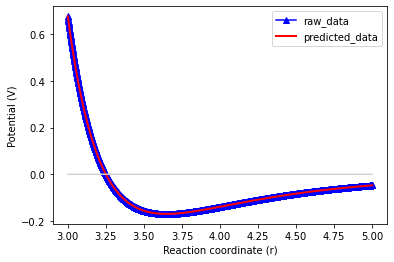

In [11]:
x = np.arange(3, 5.0, 0.001)     # x value
y_truth = lennard_jones(x)       # true function value

def lj_complicated(x, pow1, pow2, epsilon, sigma):
    return 4 * epsilon * ((sigma/x)**pow1 - (sigma/x)**pow2)

x_data = x
y_data = y_truth

popt, pcov = curve_fit(lj_complicated, x_data, y_data)
print(f"The parameters are: {popt}")

dash_line_x = x
dash_line_y = np.array([0] * len(x))

plt.plot(x_data, y_data, 'b-', marker='^', label='raw_data')
plt.plot(x_data, lj_complicated(x_data, *popt), 'r-', linewidth=2, label='predicted_data')
plt.plot(dash_line_x, dash_line_y, color='lightgrey')
plt.xlabel('Reaction coordinate (r)')
plt.ylabel('Potential (V)')
plt.legend()
plt.show()